In [8]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 35})

In [2]:
# read all of the data
# https://github.com/mttk/STL10
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
def show_images(data,row=1,col=1):
    fig=plt.figure(figsize=(10,10))
    columns = col; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(data[i-1])
    plt.show()

train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [10]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)

def tf_elu(x):   return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=4,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer,self.layerA
    
    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        
        return grad_pass,grad,update_w
    
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

class tf_layer_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w * self.c)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
    
class tf_instance_norm_layer():
    
    def __init__(self,batch_size,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
  
class tf_box_cox():
    
    def __init__(self):
        self.lmbda    = tf.Variable(2.0) 
        self.m,self.v = tf.Variable(tf.zeros_like(self.lmbda)),tf.Variable(tf.zeros_like(self.lmbda))
    def getw(self): return self.lmbda
    
    def feedforward(self,data):
        self.input = data
        self.layer = tf.pow((self.input + 1.0),self.lmbda)
        return (self.layer - 1.0)/(self.lmbda + 1e-8)
    
    def backprop(self,grad):
        
        # Gradient that gets passed along
        grad_pass = tf.pow((self.input + 1),self.lmbda-1.0) * grad
        
        # Grad respect to the lmbda value (not tested!)
        grad_lmbda1 =   (self.layer * tf.log(self.input + 1 ))/(self.lmbda + 1e-8)
        grad_lmbda2 = - (self.layer - 1)/(self.lmbda ** 2 + 1e-8)
        grad_lmbda  = tf.reduce_mean((grad_lmbda1 + grad_lmbda2)*grad)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad_lmbda)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad_lmbda ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.lmbda,tf.subtract(self.lmbda,adam_middle  )))
        
        return grad_pass,grad_lmbda,update_w
    
def save_to_image(data,name):
    l1g,l2g,l3g,l4g,l5g,l6g = data
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig(name + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')     

In [16]:
# set hyper parameter
num_epoch = 200; learning_rate = 0.0008; batch_size = 20; beta1,beta2,adam_e = 0.9,0.999,1e-9

In [15]:
# 1. Normal CNN 
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16); 
l2 = CNN(3,16,16); 
l3 = CNN(3,16,16); 

l4 = CNN(3,16,16); 
l5 = CNN(3,16,16); 
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad5n)
grad4p,grad4w,grad4_up = l4.backprop(grad4n,stride=2)

grad3p,grad3w,grad3_up = l3.backprop(grad3n,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad2n,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad1n,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'Normal/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'Normal/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'Normal/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'Normal/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save('Normal/train.npy',train_acc)
np.save('Normaltest.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/200 batch : 7980/8000 acc : 0.25
 Current : 0 Acc : 0.10820000241696835 Test Acc : 0.17150000302121043

Current Iter : 1/200 batch : 7980/8000 acc : 0.35
 Current : 1 Acc : 0.17420000280439854 Test Acc : 0.24750000319443644

Current Iter : 2/200 batch : 7980/8000 acc : 0.45
 Current : 2 Acc : 0.22760000275075434 Test Acc : 0.28162500261329115

Current Iter : 3/200 batch : 7980/8000 acc : 0.45
 Current : 3 Acc : 0.26160000275075435 Test Acc : 0.2953750019427389

Current Iter : 4/200 batch : 7980/8000 acc : 0.35
 Current : 4 Acc : 0.2766000027805567 Test Acc : 0.30250000215135514

Current Iter : 5/200 batch : 7980/8000 acc : 0.35
 Current : 5 Acc : 0.29040000224113466 Test Acc : 0.3280000017210841

Current Iter : 6/200 batch : 7980/8000 acc : 0.35
 Current : 6 Acc : 0.3174000021219254 Test Acc : 0.3348750017769635

Current Iter : 7/200 batch : 7980/8000 acc : 0.35
 Current : 7 Acc : 0.3352000017762184 Test Acc : 0.34287500208243726

Current Iter : 8/200 batch : 7980/8000

Current Iter : 68/200 batch : 7980/8000 acc : 0.25
 Current : 68 Acc : 0.5258000010251999 Test Acc : 0.4910000006109476

Current Iter : 69/200 batch : 7980/8000 acc : 0.25
 Current : 69 Acc : 0.5268000018596649 Test Acc : 0.49149999998509886

Current Iter : 70/200 batch : 7980/8000 acc : 0.35
 Current : 70 Acc : 0.5314000012874603 Test Acc : 0.4916250002011657

Current Iter : 71/200 batch : 7980/8000 acc : 0.35
 Current : 71 Acc : 0.5352000008821487 Test Acc : 0.4928750002011657

Current Iter : 72/200 batch : 7980/8000 acc : 0.25
 Current : 72 Acc : 0.5358000005483627 Test Acc : 0.4956249999254942

Current Iter : 73/200 batch : 7980/8000 acc : 0.35
 Current : 73 Acc : 0.5368000009059906 Test Acc : 0.4951250002160668

Current Iter : 74/200 batch : 7980/8000 acc : 0.35
 Current : 74 Acc : 0.5396000001430511 Test Acc : 0.4948750001937151

Current Iter : 75/200 batch : 7980/8000 acc : 0.35
 Current : 75 Acc : 0.5392000013589859 Test Acc : 0.49875000096857547

Current Iter : 76/200 batch : 

Current Iter : 135/200 batch : 7980/8000 acc : 0.55
 Current : 135 Acc : 0.6223999996185303 Test Acc : 0.5276250011846423

Current Iter : 136/200 batch : 7980/8000 acc : 0.55
 Current : 136 Acc : 0.6236000002622605 Test Acc : 0.5272500010952353

Current Iter : 137/200 batch : 7980/8000 acc : 0.55
 Current : 137 Acc : 0.6237999994754791 Test Acc : 0.5281250010803342

Current Iter : 138/200 batch : 7980/8000 acc : 0.55
 Current : 138 Acc : 0.6251999995708466 Test Acc : 0.52750000115484

Current Iter : 139/200 batch : 7980/8000 acc : 0.55
 Current : 139 Acc : 0.6261999998092651 Test Acc : 0.52812500115484

Current Iter : 140/200 batch : 7980/8000 acc : 0.55
 Current : 140 Acc : 0.6255999991893768 Test Acc : 0.5285000010207296

Current Iter : 141/200 batch : 7980/8000 acc : 0.55
 Current : 141 Acc : 0.6283999992609024 Test Acc : 0.5295000013336539

Current Iter : 142/200 batch : 7980/8000 acc : 0.65
 Current : 142 Acc : 0.6303999989032746 Test Acc : 0.5280000016465783

Current Iter : 143/2

In [29]:
sess.InteractiveSession.close()

AttributeError: 'InteractiveSession' object has no attribute 'InteractiveSession'

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/200 batch : 7980/8000 acc : 0.25
 Current : 0 Acc : 0.24600000274181366 Test Acc : 0.22687500347383321



KeyboardInterrupt: 

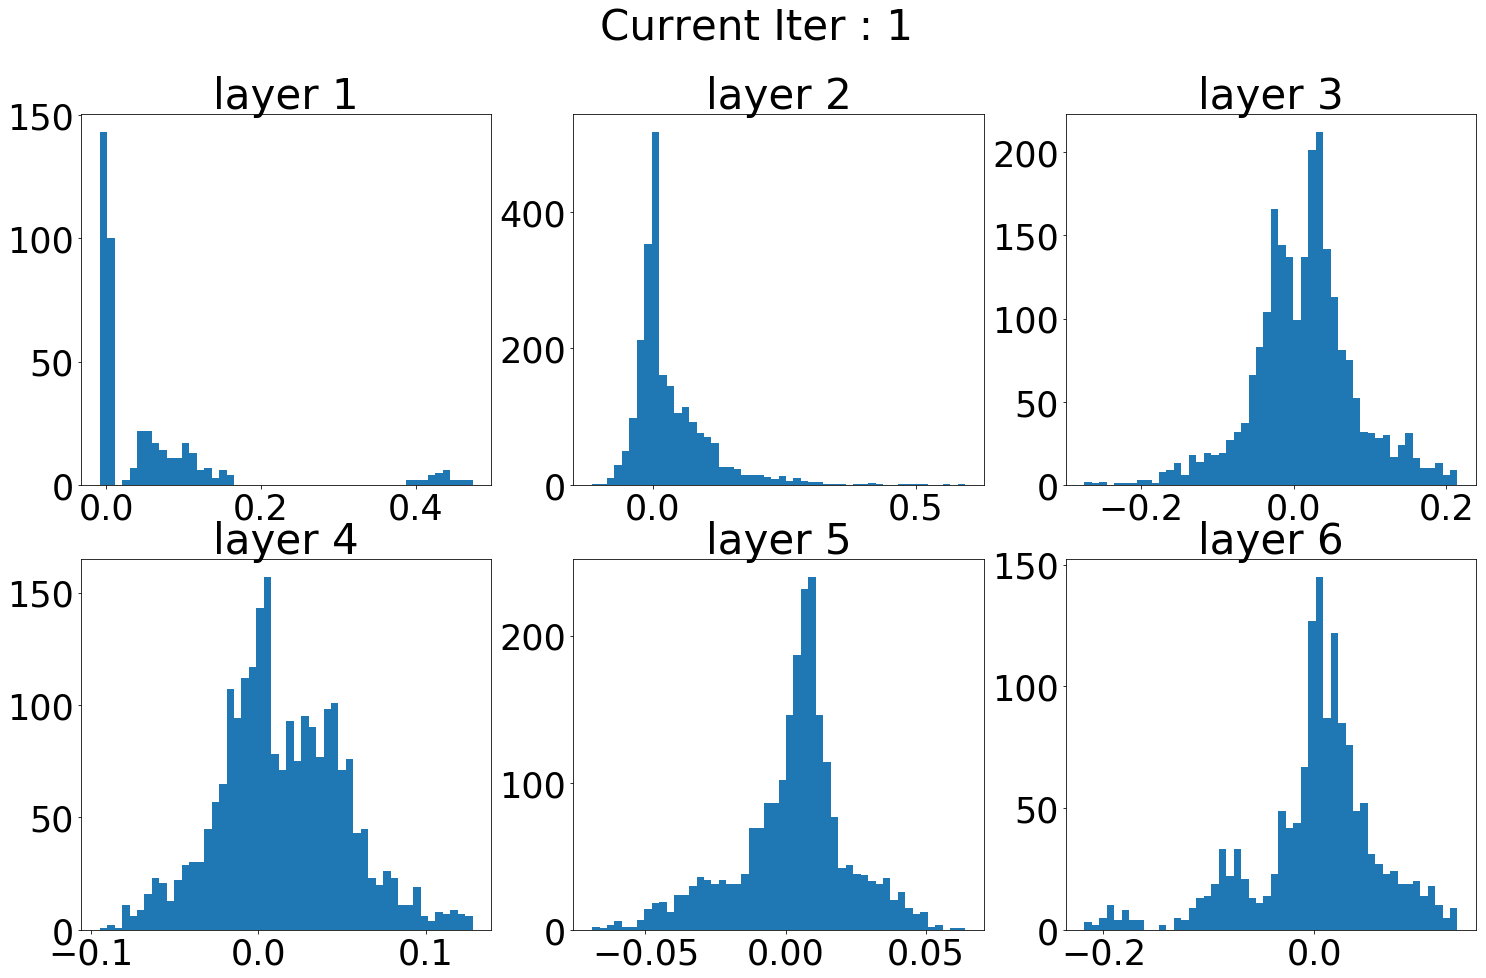

In [24]:
# 2. batch normalization
sess = tf.InteractiveSession()

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_batch_norm_layer(16,(0,1,2))
l2 = CNN(3,16,16); l2n = tf_batch_norm_layer(16,(0,1,2))
l3 = CNN(3,16,16); l3n = tf_batch_norm_layer(16,(0,1,2))
l4 = CNN(3,16,16); l4n = tf_batch_norm_layer(16,(0,1,2))
l5 = CNN(3,16,16); l5n = tf_batch_norm_layer(16,(0,1,2))
l6 = CNN(3,16,10); 

# create the graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)
layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5n = l5n.backprop(grad6p)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4n = l4n.backprop(grad5p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)

grad3n = l3n.backprop(grad4p)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2n = l2n.backprop(grad3p)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1n = l1n.backprop(grad2p)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

update_ops  = update1 + update2 + update3 + update4 + update5
gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = []; test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'batch Norm/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'batch Norm/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'batch Norm/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'batch Norm/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
   
np.save('batch Norm/train.npy',train_acc)
np.save('batch Norm/test.npy', test_acc)
sess.close()
tf.reset_default_graph();

# Reference
1. mttk/STL10. (2018). GitHub. Retrieved 19 December 2018, from https://github.com/mttk/STL10
2. [duplicate], H. (2018). How to display multiple images in one figure correctly?. Stack Overflow. Retrieved 19 December 2018, from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
3. plot, H. (2010). How to change the font size on a matplotlib plot. Stack Overflow. Retrieved 20 December 2018, from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
